In [ ]:
import os
from google.colab import drive

# Connect to Google Drive
drive.mount('/content/gdrive')

# Go to the root drive folder
os.chdir('/content/gdrive/MyDrive/INASCON2021')


In [6]:
# import some stuff

import math
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt


In [7]:
# A function that calculates Mean-Square-Displacement for a time series
# It returns 4 outputs:
# (msd, lag, std, n) = FastMSD(x)
#
# "msd" is the calculated result, for lags "lag" (multiply by the sampling interval to get the lag time)
# "std" is the array of standard deviations
# "n" has the number of samples per lag
def FastMSD(v):
    # Calculate differences
    v = np.diff(v, 1, 0)

    max_power2 = int(math.floor(math.log2(v.shape[0])))

    lag = np.array(list(math.pow(2, p) for p in range(max_power2))) # time lag
    msd = np.zeros(max_power2) # MSD
    n = np.zeros(max_power2) # number of samples
    std = np.zeros(max_power2) # standard deviation

    for p in range(max_power2):
        x = np.square(v) # Square
        x = np.sum(x, 1) # Sum over vector components
        msd[p] = np.mean(x) # Mean-square-displacement
        std[p] = np.std(x) # Calculate the spread of the result
        n[p] = x.shape[0] # Keep number of samples

        s = v.shape
        v = [v[2*i, :] + v[2*i + 1, :] for i in range(s[0]//2)]
        v = np.array(v) # convert to NumPy array for convenience

    return (msd, lag, std, n)


In [10]:
# A simple code for a bounded random walk, as an example, instead of loading data

import random

dt = 1 # sampling interval
L = 100
results = []

for L in (10, 20, 50, 100):
    pos = np.array((0.0, 0.0));
    xy = []

    for i in range(100000):
        step = np.array((random.gauss(0, 1), random.gauss(0, 1)))
        updated_pos = pos + step    

        if (updated_pos[0] >= 0 and updated_pos[1] >= 0 and updated_pos[0] < L and updated_pos[1] < L):
            pos = updated_pos
            xy.append(pos)

    results.append(FastMSD(xy))


In [6]:
# Load data and calculate MSDs

data = np.loadtxt('data/HD_N100_L100_every1.txt', delimiter=' ')
dt = 1 # sampling interval

# The data is shapes like [frames]x[N * 2]
# For XY (2) coordinates of N bots over time
# Reshape to 3d array [frames]x[N]x[2]
s = data.shape
N = s[1] // 2
data = data.reshape((s[0], N, 2))

# Calculate MSDs independently for all bots
results = list([FastMSD(data[:, s, :]) for s in range(N)])


NameError: name 'dt' is not defined

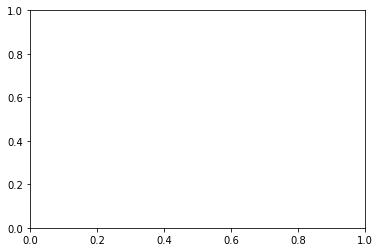

In [9]:
# Display calculated MSDs

#fig = plt.figure()
fig, ax = plt.subplots()
for s in range(len(results)):
    (msd, lag, std, n) = results[s]
    plt.loglog(lag * dt, msd)

ax.set_ylabel('Mean-square-displacement (m^2)')
ax.set_xlabel('Time lag (sec)')
plt.show()


#fig = plt.figure()
fig, ax = plt.subplots()

msd_arrays = [results[s][0] for s in range(len(results))]
msd = np.mean(msd_arrays, 0) # Mean, over first dimension (bots)
lag = results[0][1] * dt # They all have the same list of lags, just pick one

plt.loglog(lag, msd, label='Mean of MSDs')
plt.loglog(lag, msd[0] * np.power(lag / lag[0], 1), dashes=[6, 3], label='Diffusive (t)') # for reference
plt.loglog(lag, msd[0] * np.power(lag / lag[0], 2), dashes=[6, 3], label='Ballistic (t^2)') # for reference

ax.set_ylabel('Mean-square-displacement (m^2)')
ax.set_xlabel('Time lag (sec)')

ax.legend()
plt.show()
